In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from utils import u_darrays as uda, constants as cnst
import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from utils import u_darrays
import ipdb
from utils import constants as cnst, u_met
import salem
from utils import u_statistics as us
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
from scipy import stats

%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def calc_trend(data, month, hour=None, method=None, sig=False, wilks=False):

    y1 = 1985
    y2 = 2019

    if method is None:
        'Please provide trend calc method: polyfit or mk (mann kendall)'
    if hour is not None:

        if len(month)>1:

            data = data[((data['time.month'] >= month[0]) & (data['time.month'] <= month[1])) & (data['time.hour'] == hour) & (data['time.year'] >= y1) & (data['time.year'] <= y2)]
        else:

            data = data[(data['time.month'] == month[0]) & (data['time.hour'] == hour) & (data['time.year'] >= y1) & (data['time.year'] <= y2)]
    else:
        if len(month)>1:
            data = data[((data['time.month'] >= month[0]) & (data['time.month'] <= month[1]))& (data['time.year'] >= y1) & (data['time.year'] <= y2)]
        else:
            data = data[(data['time.month'] == month[0]) & (data['time.year'] >= y1) & (data['time.year'] <= y2)]

    if len(data.time)==0:
        print('Data does not seem to have picked month or hour. Please check input data')

    mean_years = data.groupby('time.year').mean('time')

    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['latitude', 'longitude'])


    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.01,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='linregress':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_lingress,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = 0
            
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_polyfit,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = 0

    ddtrend = dtrend['slope']

#     if wilks and sig:
#         try:
#             pthresh = us.fdr_threshold(dtrend['pval'].values[np.isfinite(dtrend['pval'].values)], alpha=alpha)
#             ddtrend.values[(dtrend['pval'].values > pthresh) | np.isnan(dtrend['pval'].values)] = np.nan
#         except ValueError:
#             ddtrend.values = ddtrend.values * np.nan
#             pthresh = np.nan
#         print('p value threshold', pthresh)
    #ipdb.set_trace()
    # unstack back to lat lon coordinates
    
    ddout = dtrend #uda.flip_lat(dtrend)
    
    return ddout, mean_years

In [4]:
mcs = '/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.monthly.nc'
fpath = cnst.network_data + 'figs/HUARAZ/'
da3 = xr.open_dataarray(mcs).sel(latitude=slice(-11,-8), longitude=slice(-79, -76)) #.sel(latitude=slice(-10.2,-8.63), longitude=slice(-78, -77))#/100   #
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)
da3 = da3.salem.roi(shape=sdf)

In [5]:
fmcs = '/media/ck/Elements/global/GPM/*.nc4'
fpath = cnst.network_data + 'figs/HUARAZ/'
gpm = xr.open_mfdataset(fmcs).sel(lat=slice(-11,-8), lon=slice(-79, -76)) #.sel(latitude=slice(-10.2,-8.63), longitude=slice(-78, -77))#/100   
gpm = gpm['precipitation']
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)
gpm = gpm.salem.roi(shape=sdf)

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


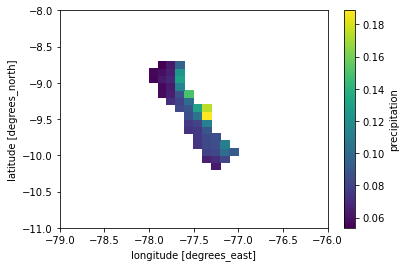

In [6]:
gpm.mean('time').T.plot()

In [7]:
sdf

,COUNT,FLAECHE,RIOSAN,max_x,max_y,min_x,min_y,geometry
0,113.0,4.421497e+09,1,-77.020021,-8.633822,-77.998542,-10.235552,"POLYGON ((-77.90790 -8.72631, -77.90828 -8.725..."


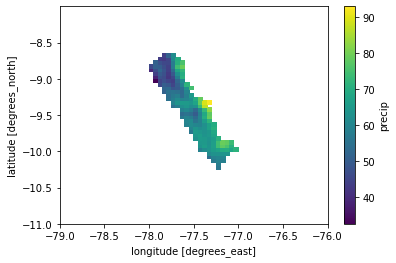

In [8]:
da3.mean('time').plot()

In [9]:
ndvif = '/home/ck/DIR/cornkle/data/HUARAZ/Lorenz_NDVI/RioSanta_NDVI_monthly.nc'
fpath = cnst.network_data + 'figs/HUARAZ/'
ndvi = xr.open_dataarray(ndvif)#/100

In [10]:
fmcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_count_-20_allClouds_monthly.nc'
mcs = xr.open_mfdataset(fmcs).sel(lat=slice(-11,-8), lon=slice(-79, -76)) #.sel(latitude=slice(-10.2,-8.63), longitude=slice(-78, -77))#/100   
mcs = mcs['tir']
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)
mcs = mcs.salem.roi(shape=sdf)

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


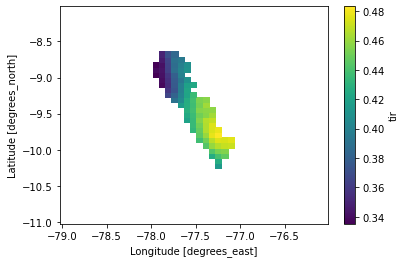

In [11]:
mcs.mean('time').plot()

In [12]:
da3 = da3[(da3['time.year'] >2000) & (da3['time.year'] <2019)] 
gpm = gpm[(gpm['time.year'] >2000) & (gpm['time.year'] <2019)] 
ndvi = ndvi[(ndvi['time.year'] >2000) & (ndvi['time.year'] <2019)] 
mcs = mcs[(mcs['time.year'] >2000) & (mcs['time.year'] <2019)] 

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(-78.1, -76.9)

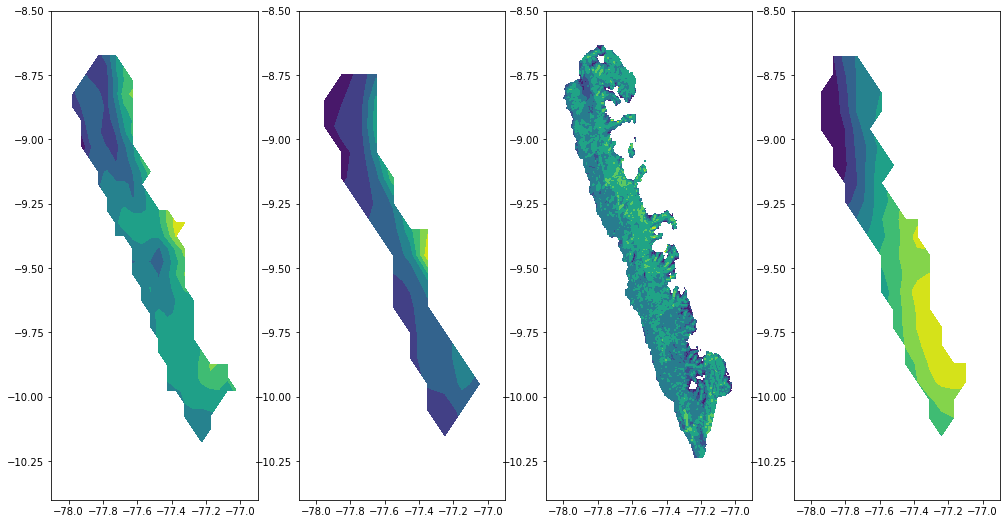

In [13]:
f = plt.figure(figsize=(17,9))
ax = f.add_subplot(141)
ax.contourf(da3.longitude, da3.latitude, da3.mean('time'))
ax.set_ylim(-10.4,-8.5)
ax.set_xlim(-78.1,-76.9)

ax = f.add_subplot(142)
ax.contourf(gpm.lon, gpm.lat, gpm.mean('time').T*24*30)
ax.set_ylim(-10.4,-8.5)
ax.set_xlim(-78.1,-76.9)

ax = f.add_subplot(143)
ax.contourf(ndvi.lon, ndvi.lat, ndvi.mean('time'))
ax.set_ylim(-10.4,-8.5)
ax.set_xlim(-78.1,-76.9)

ax = f.add_subplot(144)
ax.contourf(mcs.lon, mcs.lat, mcs.mean('time'))
ax.set_ylim(-10.4,-8.5)
ax.set_xlim(-78.1,-76.9)


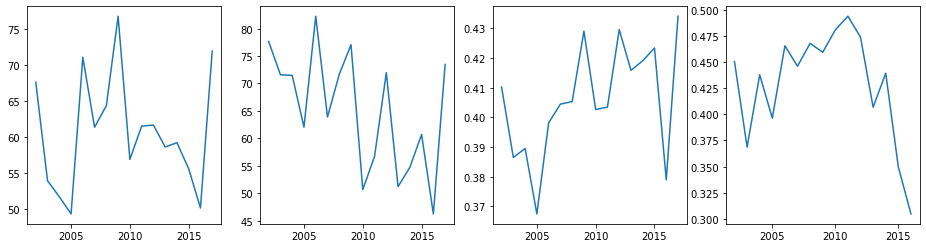

In [14]:
f = plt.figure(figsize=(16,4))
ax = f.add_subplot(141)
ax.plot(np.unique(da3['time.year'])[1:-1], da3.mean(['latitude','longitude']).groupby('time.year').mean('time')[1:-1])


ax = f.add_subplot(142)
ax.plot(np.unique(gpm['time.year'])[1:-1], gpm.mean(['lat','lon']).groupby('time.year').mean('time')[1:-1]*24*30)


ax = f.add_subplot(143)
ax.plot(np.unique(ndvi['time.year'])[1:-1], ndvi.mean(['lat','lon']).groupby('time.year').mean('time')[1:-1])

ax = f.add_subplot(144)
ax.plot(np.unique(mcs['time.year'])[1:-1], mcs.mean(['lat','lon']).groupby('time.year').mean('time')[1:-1])


In [15]:
da3.time

<xarray.DataArray 'time' (time: 216)>
array(['2001-01-01T00:00:00.000000000', '2001-02-01T00:00:00.000000000',
       '2001-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2018-12-01
Attributes:
    standard_name:  time
    axis:           T

In [16]:
def normalise(dat):
    mini = np.min(dat)
    maxi = np.max(dat)
    return (dat-mini)/(maxi-mini)

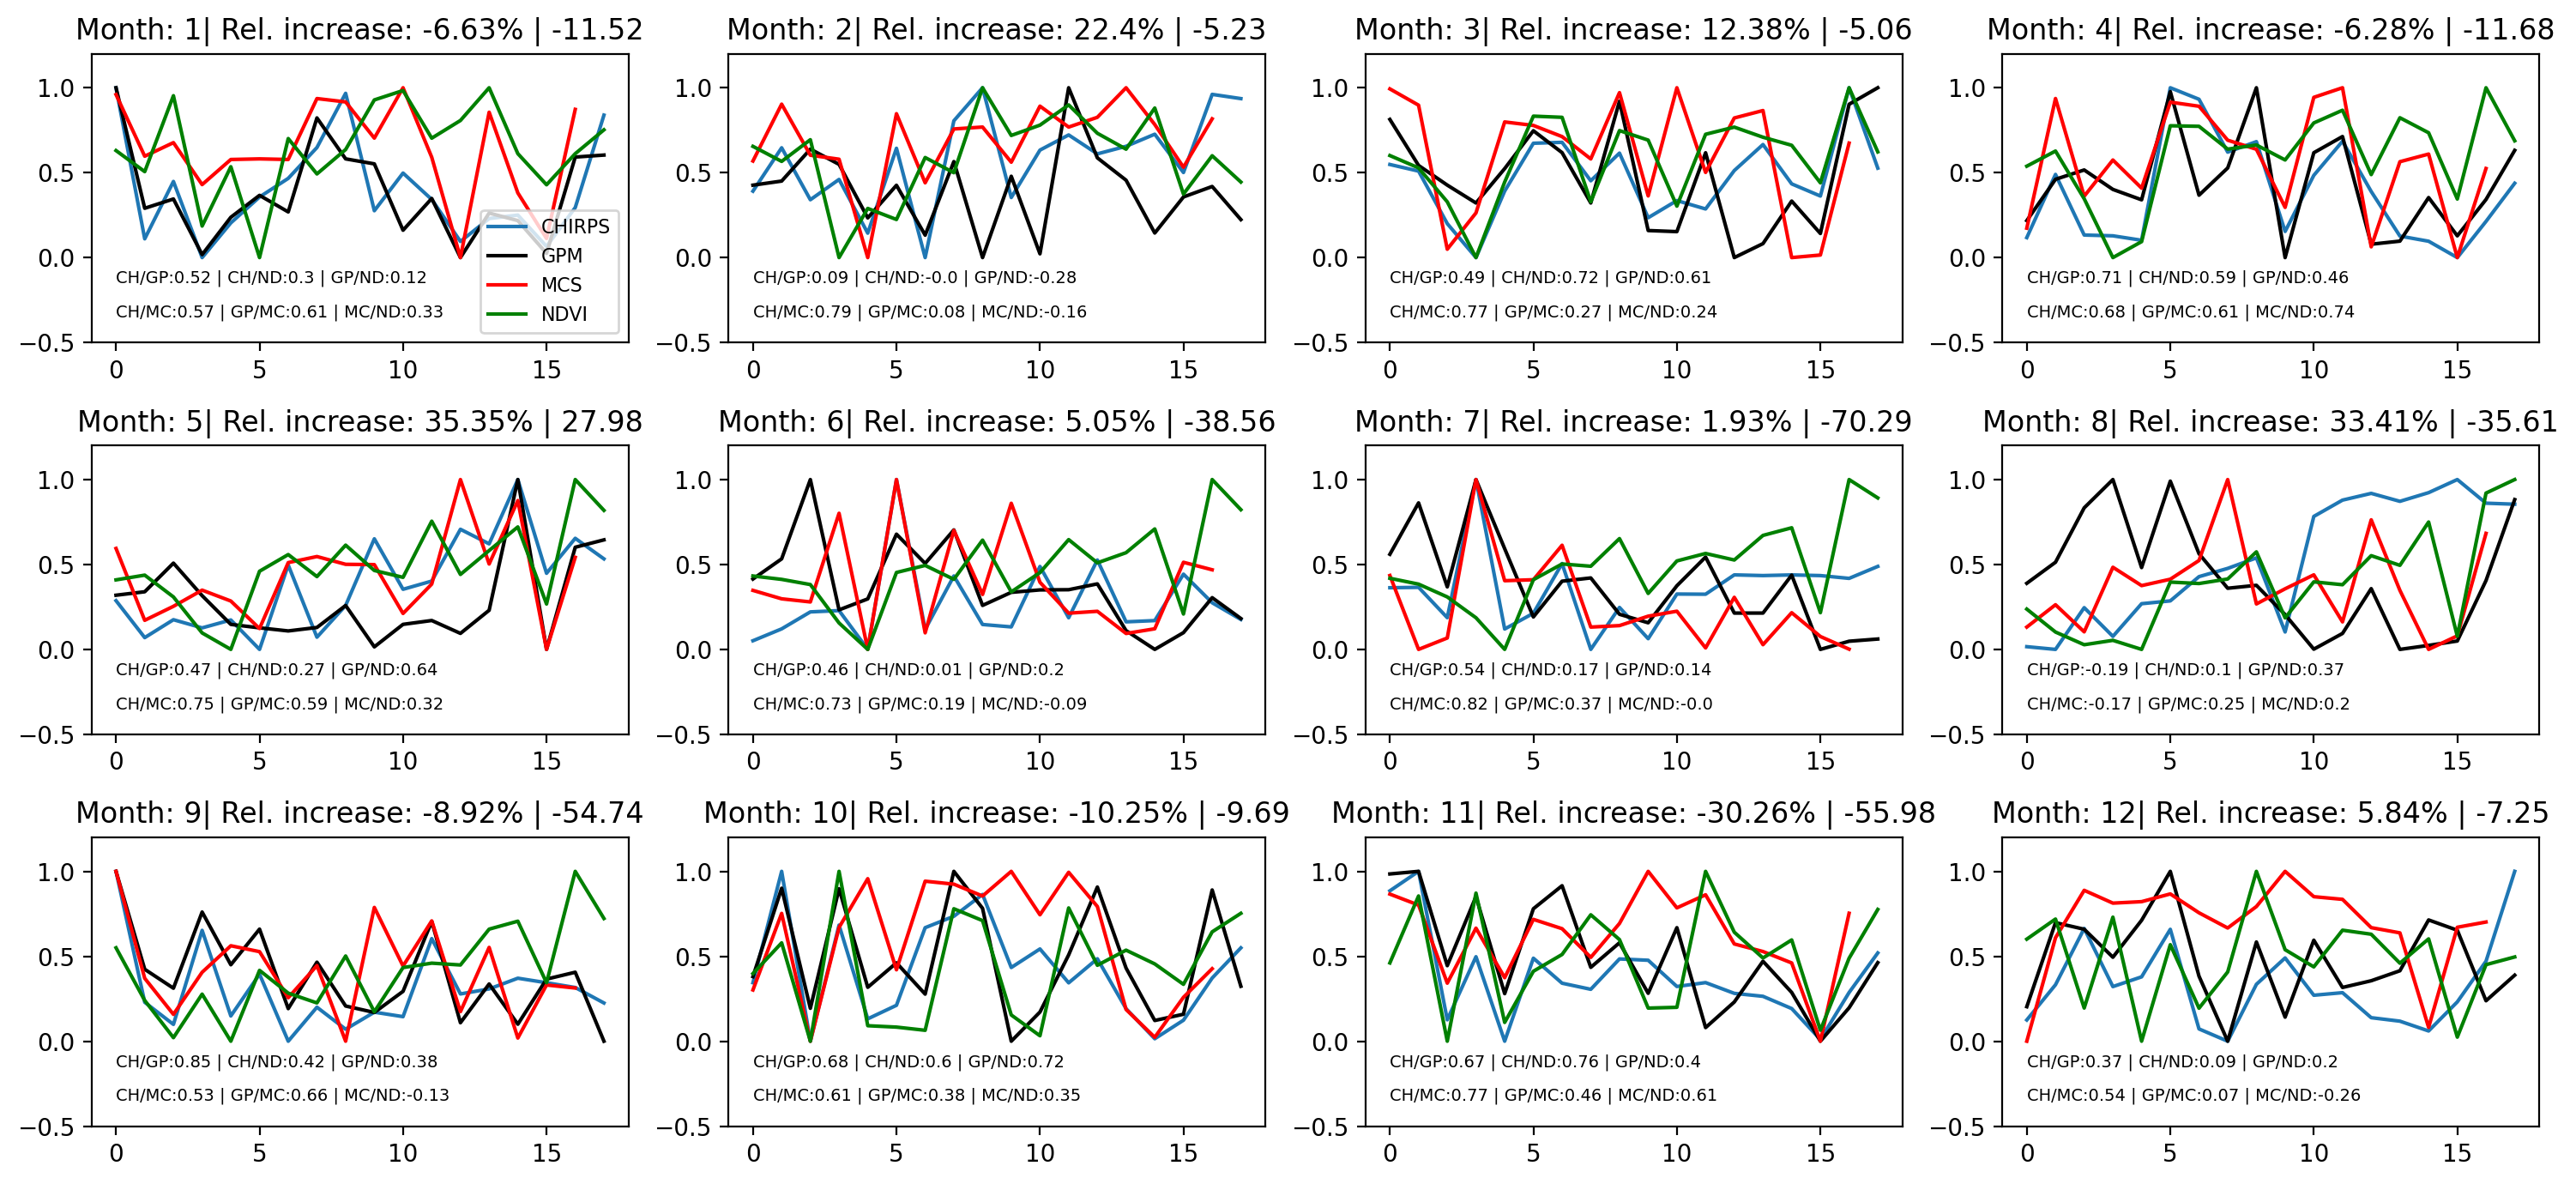

In [18]:
f = plt.figure(figsize=(15,7), dpi=200)
for ids, mm in enumerate([1,2,3,4,5,6,7,8,9,10,11,12]):

    ax = f.add_subplot(3,4,ids+1)
    sep = da3[da3['time.month']==mm].mean(['latitude', 'longitude'])
    nd = ndvi[ndvi['time.month']==mm].mean(['lat', 'lon'])
    sep2 = gpm[gpm['time.month']==mm].mean(['lat', 'lon'])*24*30
    
    mc = mcs[mcs['time.month']==mm].mean(['lat', 'lon'])
    
    slope, ints = np.polyfit(np.arange(len(sep)), sep, 1)
    slope2, ints2 = np.polyfit(np.arange(len(sep2)), sep2, 1)
    ax.plot(normalise(sep), '-', label='CHIRPS')
    ax.plot(normalise(sep2), '-k', label='GPM')
    ax.plot(normalise(mc), '-r', label='MCS')
    ax.set_ylim(-0.5,1.2)
    
   # ipdb.set_trace()
    seps = sep[1::].values-sep[0:-1].values
    seps2 = sep2[1::].values-sep2[0:-1].values
    nds = nd[1::].values-nd[0:-1].values
    
   # ipdb.set_trace()
    
    ax.text(0,-0.15, 'CH/GP:'+str(np.round(stats.pearsonr(seps, seps2)[0],2))+' | CH/ND:'+str(np.round(stats.pearsonr(seps, nds)[0],2))+' | GP/ND:'+str(np.round(stats.pearsonr(seps2, nds)[0],2)), fontsize=7)
    
    seps = sep[1:-1].values-sep[0:-2].values
    seps2 = sep2[1:-1].values-sep2[0:-2].values
    nds = nd[1:-1].values-nd[0:-2].values
    mcss = mc[1::].values-mc[0:-1].values
    ax.text(0,-0.35, 'CH/MC:'+str(np.round(stats.pearsonr(seps, mcss)[0],2))+' | GP/MC:'+str(np.round(stats.pearsonr(seps2, mcss)[0],2))+' | MC/ND:'+str(np.round(stats.pearsonr(mcss, nds)[0],2)), fontsize=7)

    ax.plot(normalise(nd), '-g', label='NDVI')

    plt.title('Month: '+str(mm)+ '| Rel. increase: '+str(np.round(slope*10/np.mean(sep.values)*100,2))+'% | '+str(np.round(slope2*10/np.mean(sep2.values)*100,2)))
    if ids == 0:
        plt.legend(fontsize=8, loc='lower right')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/GPM_CHIRPS_NDVI_mean_2000-2019.jpg')